In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from scipy.interpolate import interp1d
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings("ignore")

# Set style for the plots
plt.style.use('seaborn-v0_8')

In [2]:
df = pd.read_csv('../data/processed/water_levels_daily.csv', parse_dates=['timestamp'])
series = df.set_index('timestamp')['value'].asfreq('W')
series

timestamp
2000-01-02    239.42
2000-01-09    239.45
2000-01-16    239.03
2000-01-23    239.36
2000-01-30    239.98
               ...  
2025-03-23    242.51
2025-03-30    242.51
2025-04-06    242.32
2025-04-13    241.87
2025-04-20    241.43
Freq: W-SUN, Name: value, Length: 1321, dtype: float64

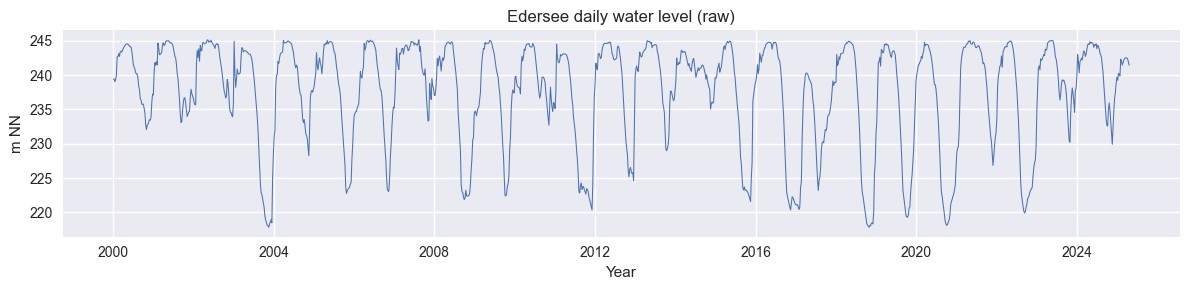

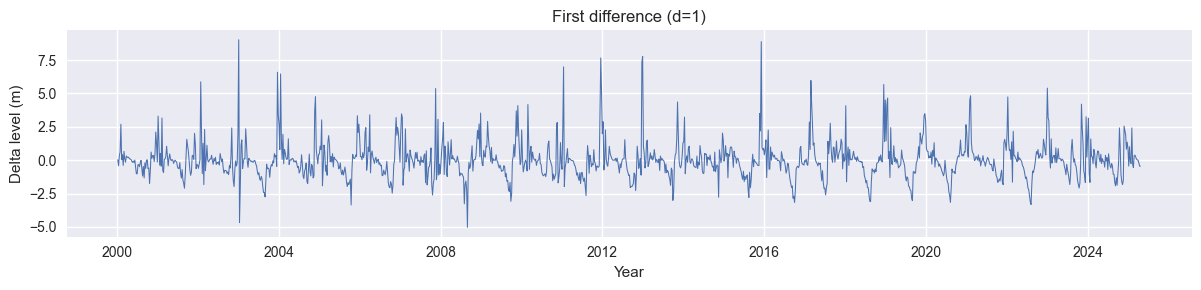

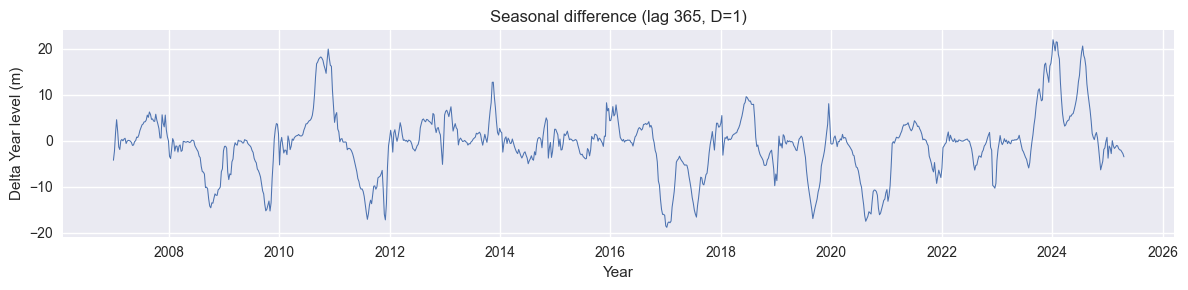

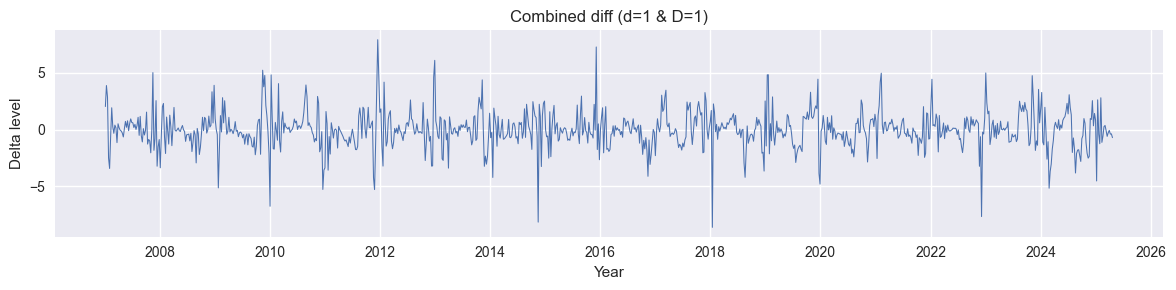

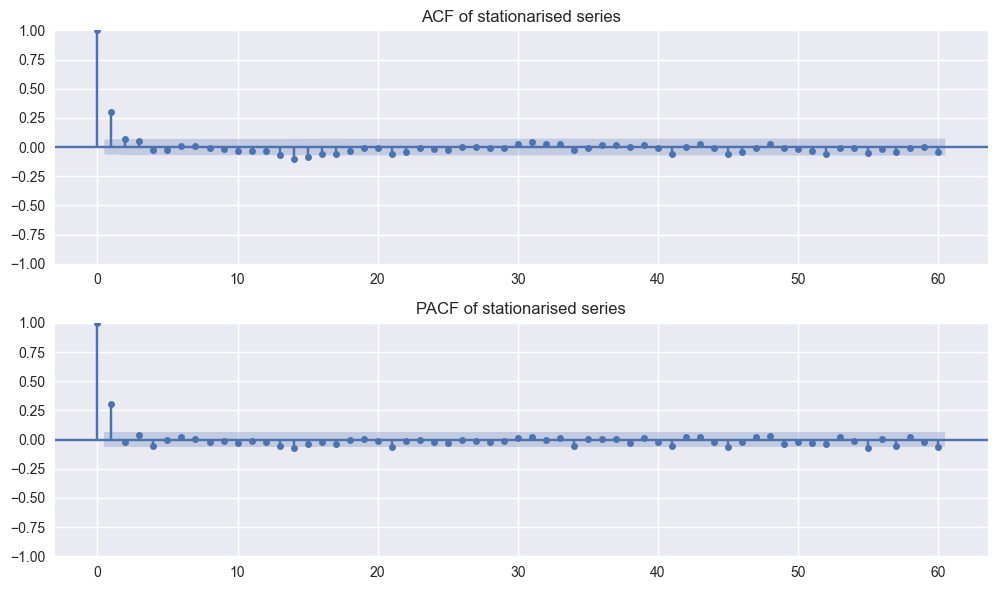

In [3]:
# ---- 1. Raw series ----
plt.figure(figsize=(12,3))
plt.plot(series, linewidth=0.75)
plt.title("Edersee daily water level (raw)")
plt.xlabel("Year")
plt.ylabel("m NN")
plt.tight_layout()
plt.show()

# ---- 2. Non‑seasonal diff (d=1) ----
d1 = series.diff().dropna()
plt.figure(figsize=(12,3))
plt.plot(d1, linewidth=0.75)
plt.title("First difference (d=1)")
plt.xlabel("Year")
plt.ylabel("Delta level (m)")
plt.tight_layout()
plt.show()

# ---- 3. Seasonal diff (lag 365, D=1) ----
D1 = series.diff(365).dropna()
plt.figure(figsize=(12,3))
plt.plot(D1, linewidth=0.75)
plt.title("Seasonal difference (lag 365, D=1)")
plt.xlabel("Year")
plt.ylabel("Delta Year level (m)")
plt.tight_layout()
plt.show()

# ---- 4. Combined diff ----
d1D1 = d1.diff(365).dropna()
plt.figure(figsize=(12,3))
plt.plot(d1D1, linewidth=0.75)
plt.title("Combined diff (d=1 & D=1)")
plt.xlabel("Year")
plt.ylabel("Delta level")
plt.tight_layout()
plt.show()

# ---- 5. ACF & PACF for combined diff ----
fig, ax = plt.subplots(2, 1, figsize=(10,6))
plot_acf(d1D1, ax=ax[0], lags=60)
plot_pacf(d1D1, ax=ax[1], lags=60, method='ywm')
ax[0].set_title("ACF of stationarised series")
ax[1].set_title("PACF of stationarised series")
plt.tight_layout()
plt.show()

In [4]:
adf_stat, adf_p, *_ = adfuller(d1D1, autolag='AIC')
print(f'ADF Statistic: {adf_stat:.3f}')
print(f'p-value: {adf_p:.3f}')

ADF Statistic: -22.628
p-value: 0.000


# Single Model

In [5]:
# Train Validation Test split
train = series[:'2018-12-31']
valid = series['2019-01-01':'2021-12-31']
test = series['2022-01-01':]

In [65]:
model = SARIMAX(
    train,
    order=(1, 1, 0),
    seasonal_order=(1, 1, 0, 52),
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

print(model.summary())
resid = model.resid

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  992
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -1617.700
Date:                            Sat, 26 Apr 2025   AIC                           3241.400
Time:                                    12:00:39   BIC                           3255.760
Sample:                                01-02-2000   HQIC                          3246.890
                                     - 12-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3315      0.018     18.815      0.000       0.297       0.366
ar.S.L52      -0.5126      0.018   

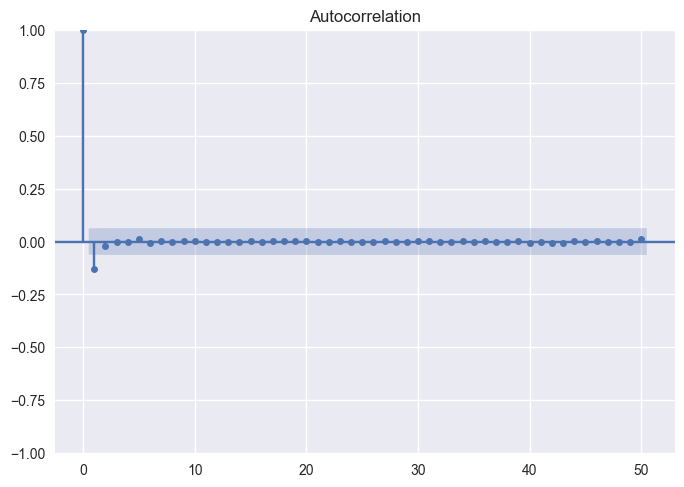

In [66]:
# Residual diagnostics
resid = model.resid
plot_acf(resid, lags=50)
plt.show()

In [68]:
acorr_ljungbox(resid, lags=[20,40], return_df=True)

,lb_stat,lb_pvalue
20,17.474922,0.621954
40,17.574564,0.999203


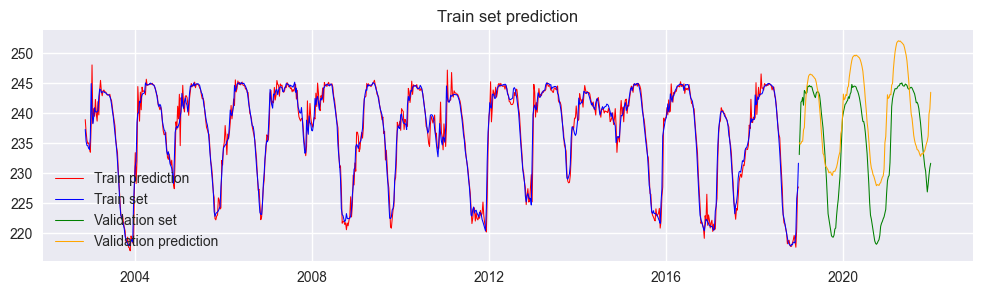

In [74]:
pred_train = model.predict(start=train.index[0], end=train.index[-1])
pred_valid = model.predict(start=valid.index[0], end=valid.index[-1])
plt.figure(figsize=(12,3))
plt.plot(pred_train[150:], color='red', linewidth=0.75, label='Train prediction')
plt.plot(train[150:], color='blue', linewidth=0.75, label='Train set')
plt.plot(valid, color='green', linewidth=0.75, label='Validation set')
plt.plot(pred_valid, color='orange', linewidth=0.75, label='Validation prediction')
plt.title("Train set prediction")
plt.legend()

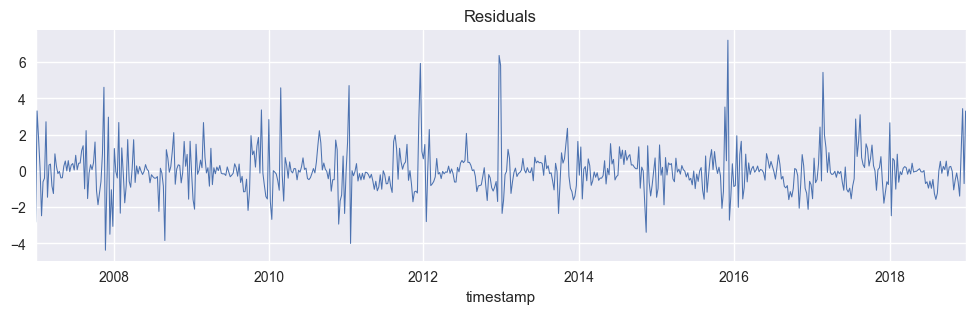

In [62]:
resid = model.resid
resid[365:].plot(title='Residuals', figsize=(12,3), linewidth=0.75)
plt.show()

In [70]:
pred = model.forecast(len(valid))
mae  = mean_absolute_error(valid, pred)
rmse = math.sqrt(mean_squared_error(valid, pred))
print(f"MAE = {mae:.2f}  RMSE = {rmse:.2f}")

MAE = 5.77  RMSE = 6.61


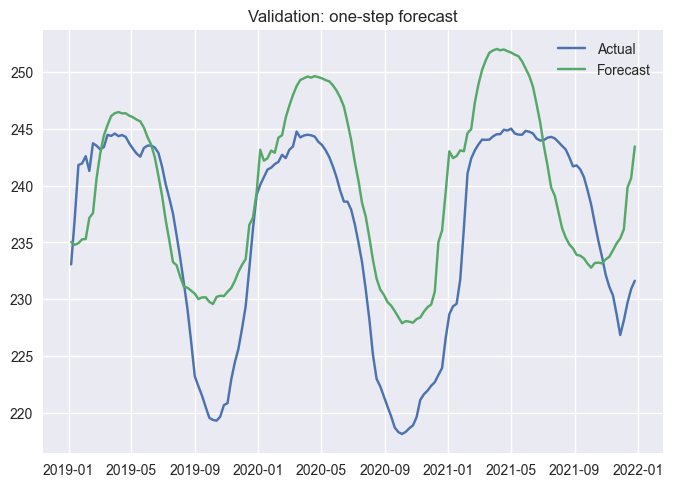

In [71]:
plt.plot(valid, label='Actual')
plt.plot(pred, label='Forecast')
plt.legend(); plt.title("Validation: one-step forecast"); plt.show()

# Rolling Window Approach

In [7]:
df = pd.read_csv('../data/processed/water_levels_daily.csv', parse_dates=['timestamp'])
df

,timestamp,value
0,2000-01-01,239.62
1,2000-01-02,239.42
2,2000-01-03,239.18
3,2000-01-04,239.09
4,2000-01-05,239.08
...,...,...
9241,2025-04-20,241.43
9242,2025-04-21,241.41
9243,2025-04-22,241.22
9244,2025-04-23,241.33


In [8]:
def undiff_sarima(pred_diff,  history, d=1, D=1, s=52):
    """
    Convert forecasts produced with simple_differencing=True back
    to the original scale.

    Parameters
    ----------
    pred_diff : pd.Series
        Forecasts of the differenced series (output of get_forecast).
        Its index must be consecutive to `history`.
    history : pd.Series
        Full original series used to fit the last window *including*
        the final observation y_t.
    d, D, s : int
        Non-seasonal order, seasonal order and period used in the model.

    Returns
    -------
    pd.Series  --  forecasts on the level of `history`.
    """
    y = history.copy()
    out = []
    for w in pred_diff:                       # iterate over the steps 1…h
        level = w
        if D:
            level += y.iloc[-s]               # add y_{t+h-s}
            if d:
                level -= y.iloc[-s-1]         # subtract y_{t+h-s-1}
        if d:
            level += y.iloc[-1]               # add y_{t+h-1}

        new_index = y.index[-1] + pd.offsets.Week()
        y.loc[new_index] = level              # append for subsequent steps
        out.append(level)

    return pd.Series(out, index=pred_diff.index)

In [9]:
# 1. Load raw data and build weekly series (mean over W–SUN weeks)
weekly = (
    df
    .set_index('timestamp')['value']
    .resample('W-SUN')
    .mean()
    .interpolate()
)

# 2. Define validation window and index for rolling forecast
valid = weekly['2018-01-01':'2020-12-31']
idx   = valid.index

# 3. Precompute Fourier features for annual seasonality (52-week period)
periods = [52]
t = np.arange(len(weekly))
fourier_terms = pd.DataFrame(index=weekly.index)
for P in periods:
    fourier_terms[f"sin_{P}w"] = np.sin(2 * np.pi * t / P)
    fourier_terms[f"cos_{P}w"] = np.cos(2 * np.pi * t / P)

# 4. Anchor points for Hochwasserschutzraum (Pegel in m ü. NN)
anchor_template  = [
    ("11-01", 237.30),
    ("12-15", 237.30),
    ("01-01", 239.61),
    ("02-01", 241.71),
    ("03-01", 242.70),
    ("04-01", 244.10),
    ("05-01", 244.95),
]

# 5. Function to compute the weekly “max_level” by piecewise-linear interp
def compute_max_level_series(dates):
    def max_level_on(date):
        # determine the “management year” Nov1(date.year)→May1(date.year+1)
        y0 = date.year if date.month >= 11 else date.year - 1
        # build the seven anchor datetimes for this cycle
        pts = []
        for md, lvl in anchor_template:
            mon, day = map(int, md.split("-"))
            year = y0 if mon >= 11 else y0 + 1
            pts.append((pd.Timestamp(year, mon, day), lvl))
        pts.sort(key=lambda x: x[0])
        # if before Nov 1 or after May 1: full stau
        if date < pts[0][0] or date >= pts[-1][0]:
            return pts[-1][1]
        # find segment containing date
        for (d0, l0), (d1, l1) in zip(pts, pts[1:]):
            if d0 <= date <= d1:
                frac = (date - d0) / (d1 - d0)
                return l0 + frac * (l1 - l0)
        # fallback
        return pts[-1][1]

    return pd.Series([max_level_on(d) for d in dates], index=dates, name="max_level_m")

# compute the dynamic max_level at weekly timestamps
max_level = compute_max_level_series(weekly.index)

# 8. Rolling‐window SARIMAX forecast with dynamic capping
window_weeks   = 5 * 52
order          = (1, 1, 0)
seasonal_order = (0, 0, 0, 0)  # seasonality via Fourier
horizon        = 4
MIN_VAL        = 205           # plausible physical minimum

pred_vals, ci_low, ci_high = [], [], []
cached_params = None

pbar = tqdm(total=len(idx), desc="Rolling forecast")
for target_date in idx:
    # 8a. Define training window
    train_end   = target_date - pd.offsets.Week(horizon)
    train_start = train_end - pd.offsets.Week(window_weeks - 1)
    y_window    = weekly.loc[train_start:train_end]

    # 8b. Slice exogenous for fit & forecast
    exog_train = fourier_terms.loc[train_start:train_end]
    fc_index   = pd.date_range(train_end + pd.offsets.Week(),
                               periods=horizon, freq='W-SUN')
    exog_fc    = fourier_terms.reindex(fc_index)

    # 8c. Specify and fit SARIMAX
    mod = SARIMAX(
        y_window,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
        filter_concentrated=True
    )
    res = mod.fit(
        disp=False,
        start_params=None if cached_params is None else cached_params,
        method="lbfgs",
        maxiter=50,
        hessian=False
    )
    cached_params = res.params

    # 8d. Forecast 4 weeks ahead
    fc = res.get_forecast(steps=horizon, exog=exog_fc)
    yhat_raw       = fc.predicted_mean.iloc[-1]
    lo_raw, hi_raw = fc.conf_int().iloc[-1]

    # 8e. Apply dynamic upper cap according to Hochwasserschutzraum
    dyn_max = max_level.loc[target_date]
    yhat    = min(max(yhat_raw, MIN_VAL), dyn_max)
    lo      = min(max(lo_raw,   MIN_VAL), dyn_max)
    hi      = min(max(hi_raw,   MIN_VAL), dyn_max)

    pred_vals.append(yhat)
    ci_low .append(lo)
    ci_high.append(hi)

    pbar.update()
pbar.close()

Rolling forecast:   0%|          | 0/156 [00:00<?, ?it/s]

In [10]:
rolling_pred = pd.Series(pred_vals, index=valid.index, name="y_hat")
ci_lo        = pd.Series(ci_low,   index=valid.index, name="lo_95")
ci_hi        = pd.Series(ci_high,  index=valid.index, name="hi_95")

mask = rolling_pred.notna() & valid.notna()

mae  = mean_absolute_error(valid[mask], rolling_pred[mask])
rmse = math.sqrt(mean_squared_error(valid[mask], rolling_pred[mask]))

metrics_df = pd.DataFrame(
    {"Metric": ["MAE", "RMSE"],
     "Value":  [mae,   rmse]}
)

metrics_df

,Metric,Value
0,MAE,1.609717
1,RMSE,2.447221


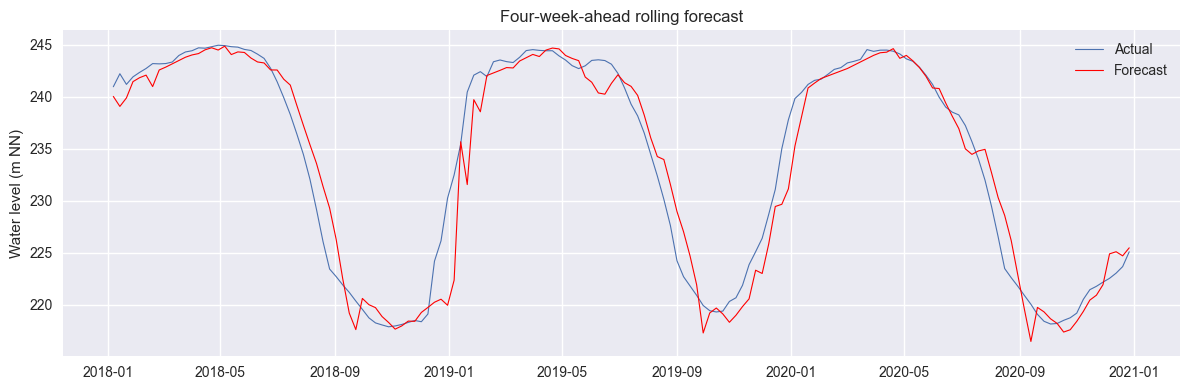

In [11]:
plt.figure(figsize=(12,4))
plt.plot(valid, label='Actual', lw=.8)
plt.plot(rolling_pred, label='Forecast', color='red', lw=.8)
plt.title("Four-week-ahead rolling forecast")
plt.ylabel("Water level (m NN)")
plt.legend()
plt.tight_layout()
plt.show()

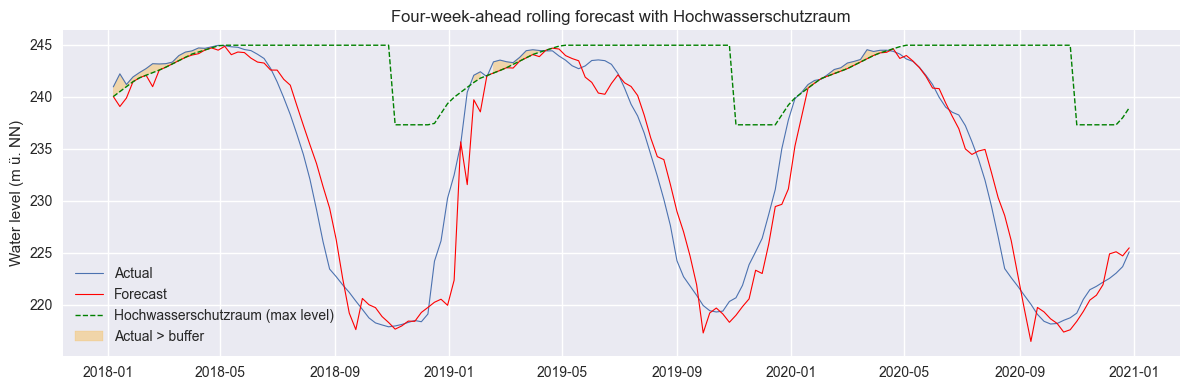

In [ ]:
ml_valid = max_level.reindex(valid.index).ffill().bfill()
ml_pred  = max_level.reindex(rolling_pred.index).ffill().bfill()

fig, ax = plt.subplots(figsize=(12,4))

# 1) plot actuals & forecasts
ax.plot(valid.index,        valid,        label='Actual',   lw=.8)
ax.plot(rolling_pred.index, rolling_pred, label='Forecast', color='red', lw=.8)

# 2) plot the buffer‐level (max allowed) as a dashed line
ax.plot(ml_valid.index,     ml_valid,
        label='Hochwasserschutzraum (max level)',
        color='green', linestyle='--', lw=1)

# 3) shade areas where actual or forecast exceed the buffer
ax.fill_between(
    valid.index,
    ml_valid,
    valid,
    where=(valid > ml_valid),
    color='orange',
    alpha=0.3,
    label='Actual > buffer'
)

# 4) finalize
ax.set_title("Four-week-ahead rolling forecast with Hochwasserschutzraum")
ax.set_ylabel("Water level (m ü. NN)")
ax.legend(loc='lower left')
plt.tight_layout()
plt.show()

,lb_stat,lb_pvalue
20,647.103178,3.351750e-124
40,712.362071,5.406643e-124


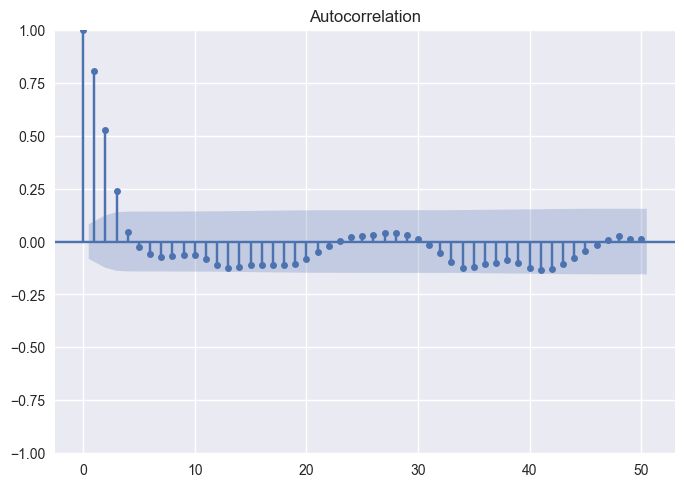

In [88]:
resid = valid - rolling_pred
plot_acf(resid, lags=50)
acorr_ljungbox(resid, lags=[20,40])